In [499]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Любая нейронная сеть это математическое выражение с параметрами, как в ЕГЭ $ y = \sqrt{R^2 -  (x - a)^2} + b $ (тут можно регулировать параметры `a`, `R`, `b`, чтобы сделать любую окружность).  
И мы хотим, чтобы это математическое выражение считало, то что мы хотим.  
У нас есть (точнее нету) функция, которую мы хотим предсказывать, которую мы хотим апроксимировать. Но у нас есть набор наблюдений поведения этой функции. Набор пар/примеров (входное значение, выходное значение) и мы хотим так подогнать параменты нашего выражения, чтобы оно давало правильные (почти) ответы на наших примерах и как следствие, работало на похожих примерах

Предположим, что это наше математическое выражение

In [500]:
def f(x, a, b):
    return a * x + b

И мы хотим, чтобы оно удовлетворяло набору примеров (точек на плоскости)  
(-1, 2)  
(2, -3)  

Для этого нам надо минимизировать разницу между выходами функции и множеством Y, варьируя параметры `a` и `b`  
Эта функция, которая как бы оценивает на сколько наше приблежения далеко от функции, которую мы пытаемся апроксимировать, называется `loss`  
И мы будем пытаться её минимизоровать

$loss = \sum_{i=0}^{n} (f(x_i, a, b) - y_i)^2 \underset{\text{a, b}}{\longrightarrow} min $ 

Если бы нам надо было искать минимум только по одной переменной `a` или `b`, то мы бы могли взять производную этой функции по этой переменной, найти точку минимума и все  
Но тут у нас две переменные.  
И все что мы можем сделать, этой найти производную по `a`, потом по `b` и сделать два маленьких шага в сторону, противоположную производной, чтобы уменьшить функцию

Распишем сумму в `loss` функции по всем двум примерам (двум нашим наблюдениям поведения искомой функции)

$ loss = (a * (-1) + b - 2)^2 + (a * 2 + b - (-3))^2 $  
$ loss = 5a^2 + 2b^2 + 4b + 13 + 2ab + 16a + 2b $

Найдем производную по `a`

$ \frac{d \space loss}{da} = \frac{d}{da} (5a^2 + 2b^2 + 4b + 13 + 2ab + 16a + 2b) = 10a + 2b + 16 $

И по `b`

$ \frac{d \space loss}{db} =  \frac{d}{db} (5a^2 + 2b^2 + 4b + 13 + 2ab + 16a + 2b) = 4b + 2a + 2 $


Вообще в этом случае можно просто решить систему, прировняв производные к 0. Но обычно параметров миллионы

Чтобы начать подбирать параметры, надо их рандомно инициализировать  
Пусть $a = b = 0 $

$ \frac{d \space loss}{da}(0, 0) = 16 $  
  
$ \frac{d \space loss}{db}(0, 0) = 2 $

Подвинем немного каждую переменную в сторону, обратную производной  
```
step = 0.1   
a -= 16 * step   
b -= 2 * step   
  
a = -1.6   
b = -0.2 
```

Сделаем следующий шаг

$ \frac{d \space loss}{da}(-1.6, -0.2) = -0.4 $ # Производная стала на много меньше. Из этого может следовать, что значение близко к оптимуму  
  
$ \frac{d \space loss}{db}(-1.6, -0.2) = -2 $

Го запрогаем

In [501]:
a = b = 0
step = 0.1
for _ in range(100):
    dLda = 10 * a + 2 * b + 16
    dLdb = 4 * b + 2 * a + 2
    a -= dLda * step
    b -= dLdb * step

In [502]:
a, b

(-1.6666666666666667, 0.3333333333333333)

Проверим, что получилось

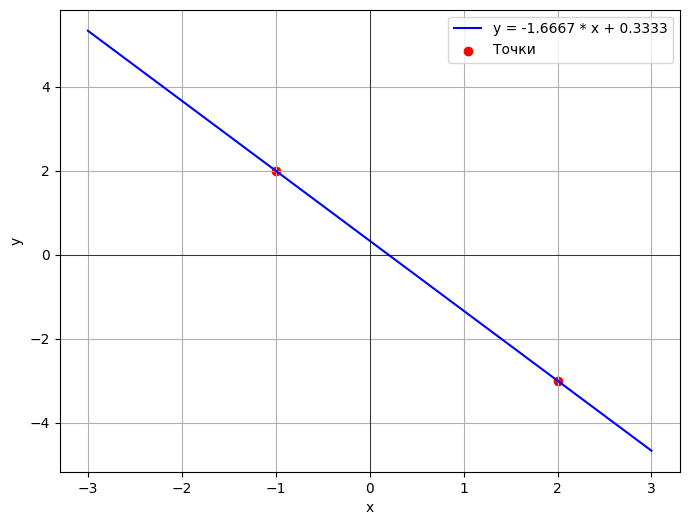

In [503]:
points = np.array([(-1, 2), (2, -3)])

x_values = np.linspace(-3, 3, 100)
y_values = a * x_values + b

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label=f'y = {a:.4f} * x + {b:.4f}', color='blue')
plt.scatter(points[:,0], points[:,1], color='red', label='Точки')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()

Параметры подобрались так, что наше математическое выражение правильно работает на наших примерах. Что мы и хотели

### Теперь давайте автоматизируем этот процесс

Нейросети представляют очень большие математические выражения.  
Давайте реализуем объект `Value`, которым будем оперировать в наших выражениях.  
Это будет аналогом `torch.tensor` в pytorch.  
Далее вместе `Value` может употребляться слово "параметр"  

У `Value` будет несколько полей.   
* `data` - числовое значение  
* `_children` - множество другиех `Value` с помощью которых было получено это значение.   
    Например если  
    ```python
    a = Value(1)
    b = Value(2)
    c = a + b
    print(c._children) # set(a, b)
    ```

  А эти параметры нужны просто для дальнейшие визуализации выражений 
* `_op` - строка в которой написано, с помощью какой операции было полученно значение. Например `"+"` или `"sigmoid"`  
* `label` - просто название переменной  

Для начала мы хотим уметь складывать и умножать `Value`

In [504]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [505]:
a = Value(-5/3, label='a')
b = Value(1/3, label='b')
x = Value(-1, label='x')
c = a * x; c.label = 'c'
y = c + b; y.label = 'y'
y

Value(data=2.0)

Тут спрятана функция, которая рисует граф операций с помощью которых было полученно какие-то `Value`. Не принципиально как она работает

In [506]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    if hasattr(n, 'grad'):
      label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad)
    else:
      label = "{ %s | data %.4f }" % (n.label, n.data)
    dot.node(name = uid, label = label, shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

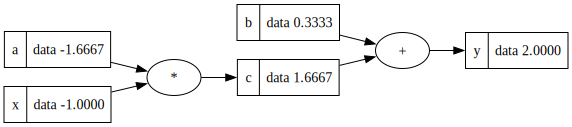

In [507]:
draw_dot(y)

Далее мы хотим для каждого `Value` посчитать по нему частную производную (чтобы, как в прошлом примере, двигать значения `Value` на размер частных производных)  
В матанализе "градиент", это вектор частных производных. В ml мы также будем называть "градиентом" значение частрой производной выражания по какому-то параметру в какой-то точке.  

Доработаем класс `Value`, чтобы считать производные  
В `self.grad` мы будем хранить значение частной производной. Изначально переменная не состоит ни в каком выражении, ни на что не влиет, поэтому поставим `self.grad = 0.0`  
Далее у нас будет функция `self._backward`, которую мы будем вызывать рекурсивно у каждого `параметра` в выражении, чтобы посчитать градиент у его `_children`, идя как бы в глубь выражения.  
```python
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
```

Предположим у нас есть выражение `F`
```
y = a * b
F = f(y)
```
Тогда `y._children = set(a, b)`   

И допустим мы уже как-то вычислили градиент `y` и он равен `y.grad`  
Мы хотим узнать градиет у значений `a` и `b`, вызвав `._backward()` у `y`. Но по началу в этот метод ничего не делает. Надо в него что-то положить.  
По логике (и правилу взятия производной сложной функции $ \frac{dF}{da} = \frac{dF}{dy} * \frac{dy}{da} $) `a.grad` должен быть равен $ \frac{dF}{dy} * \frac{dy}{da} = y.grad * b.data $. (ок, да?)  
Аналогично $ b.grad = \frac{dF}{dy} * \frac{dy}{db} = y.grad * a.data $.  
  
Давайте, при создании значения `y` через произведение `a * b` присваивать в метод `._backward` функцию, которая будет расчитывать значения градиентов у `children`, то есть у `a` и `b` в нашем случае.  
```python
class Value:
    def __mul__(self, other):
        # создаем `y` когда умножаем `a` на `b`
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out
```

В строках
```python
self.grad += other.data * out.grad 
other.grad += self.data * out.grad
```
мы делаем `+=`, а не `=`, потому что переменная/значение может встречается в выражении несколько раз.  
Например
`y = a * (a * b)`  
Тут производная по `a`, если считать на бумажке, получится  
$ \frac{dy}{da} = 2ba $  
  
А если считать алгоритмом  
`a.grad = y.grad * (a * b).data + (a * b).grad * b.data = y.grad * (a * b).data + (y.grad * a.data) * b.data`  
Если преобразовать, то получится также, как мы и посчитали руками  
`a.grad = y.grad * 2 * b * a`  

Сначала наш алгоритм посчитает градиент из первого умножения `y = a * ...`   
А потом из второго `...(a * b)`  


In [508]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out

### Проверим как работает

In [509]:
a = Value(3, label='a')
b = Value(5, label='b')
y = a * b; y.label ='y'
# пусть `y` часть какой-то функции f(y), мы знаем градиент `y` у этой функции 
y.grad = 2.0 # предположим
y._backward()
a.grad, b.grad

(10.0, 6.0)

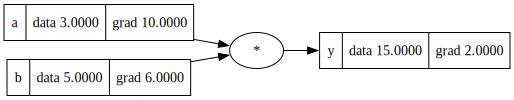

In [510]:
draw_dot(y)

Проверим на бумажке  
$ \frac{dF}{da} = \frac{dF}{dy} * \frac{dy}{da} = 2.0 * \frac{d(a * b)}{da} = 2.0 * b = 2.0 * 5 = 10 $  
  
$ \frac{dF}{db} = \frac{dF}{dy} * \frac{dy}{db} = 2.0 * \frac{d(a * b)}{db} = 2.0 * a = 2.0 * 3 = 6 $  
Все верно получилось.  


Получется, что мы должны для каждой операции, которую хотим использовать с `Value` определить, как через нее будет `течь` градиент.  
## Реализуем для сложения  
Там градиент у `children` будет такой же как у `родителя`
```py
class Value:
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
           self.grad += out.grad
           other.grad += out.grad
        out._backward = _backward
    
        return out
```

## И еще для нескольких операций
### Сделаем деление через возведение в -1ую степень

```py
class Value:
    def __pow__(self, other):
        # тут мы не хотим, чтобы other был Value, тк такая операция, где один изменяемый параметр возводится в степень другого, не используется в нейронных сетях
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        return self * other ** -1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rmul__(self, other): # other * self
        return self * other

    def __radd__(self, other): # other + self
        return self + other
```

In [511]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
           self.grad += 1.0 * out.grad
           other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        return self * other ** -1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rmul__(self, other): # other * self
        return self * other

    def __radd__(self, other): # other + self
        return self + other

## Теперь давайте посчатаем градиент сложной функции.  
Сделаем это рекурсивно для всех переменных  
Есть прикол в том, что нам надо вызывать `._backward()` только когда у родителей уже посчитан градиент.  
Чтобы понять в каком порядке делать `._backward()` отсортируем все вершины, чтобы родители были в списке раньше их детей. Это можно сделать с помощью топологической сортировки 


In [512]:
def backward(self):
    topo = []
    visited = set()
    def build_topo(v):  # топологическая сортировка
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo): # посчитаем градиент во всех вершинах
        node._backward()

Value.backward = backward

### Проверим как работает

Придумаем сложную функцию

$ f(x, a, b, c) = \frac{ax^2 + bx}{c} - \frac{a}{b+c} + x $  
  
Пусть:
```py
a = 1
b = 2
c = 3
x = 4
```

Давайте теперь вычислим производну по каждом параментру


1. Производная по \(a\):
\[
$ \frac{\partial f}{\partial a} = \frac{x^2}{c} -\frac{1}{b + c} = \frac{4^2}{3} -\frac{1}{2 + 3} = \frac{16}{3} -\frac{1}{5} = \frac{77}{15} \approx 5.13$
\]

2. Производная по \(b\):
\[
$ \frac{\partial f}{\partial b} = \frac{x}{c} + \frac{a}{(b + c)^2} = \frac{4}{3} + \frac{1}{(2 + 3)^2} = \frac{4}{3} + \frac{1}{25} = \frac{103}{75} \approx 1.37 $
\]

3. Производная по \(c\):
\[
$ \frac{\partial f}{\partial c} = - \frac{ax^2 + bx}{c^2} + \frac{a}{(b + c)^2} = - \frac{1 \cdot 4^2 + 2 \cdot 4}{3^2} + \frac{1}{(2 + 3)^2} = - \frac{16 + 8}{9} + \frac{1}{25} = -\frac{197}{75} \approx -2.63 $
\]

In [513]:
a = Value(1, label='a')
b = Value(2, label='b')
c = Value(3, label='c')
x = Value(4, label='x')

t1 = x ** 2; t1.label='t1'
t2 = a * t1; t2.label='t2'
t3 = b * x; t3.label='t3'
t4 = t2 + t3; t4.label='t4'
t5 = t4 / c; t5.label='t5'
t6 = b + c; t6.label='t6'
t7 = a / t6; t7.label='t7'
t8 = t5 - t7; t8.label='t8'
t9 = t8 + x; t9.label='t9'
t9

Value(data=11.8)

In [514]:
t9.backward()

In [515]:
a.grad, b.grad, c.grad

(5.133333333333333, 1.3733333333333333, -2.6266666666666665)

Вау, получилось как мы и предполагали

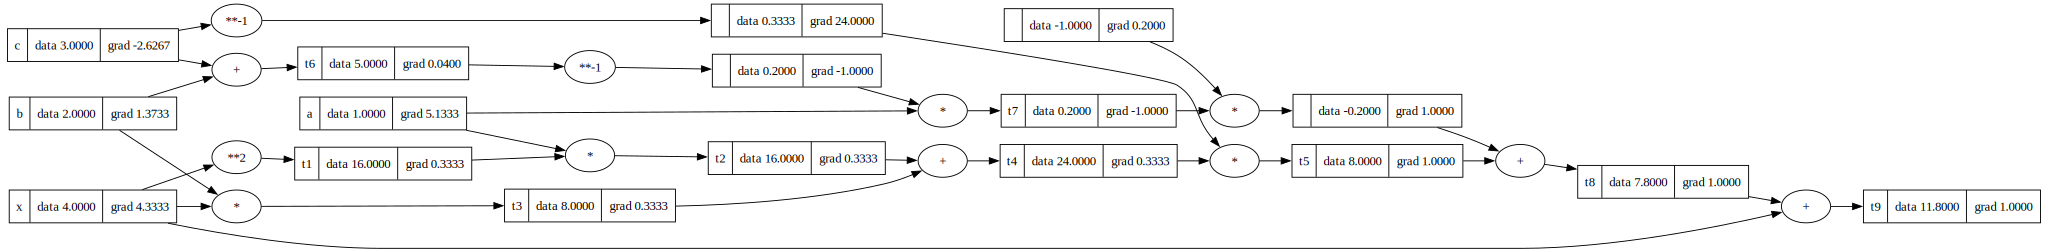

In [516]:
draw_dot(t9)

## Как это делается в pytorch

Для работы с нейросетямя есть разные фреймворки на питоне   
Мы разберем на курсе [pytorch](https://pytorch.org/tutorials/beginner/basics/intro.html) (в простонародье - торч).  
Есть еще Tensorflow, почти полностью аналогичный, только синтаксис слегка другой.  
Если понадобится, то можете разобраться [сами](https://www.tensorflow.org/tutorials).  

* [Установка торча](https://pytorch.org/get-started/locally/)
* [Туториал торча](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html)

In [717]:
* [Установка торча](https://pytorch.org/get-started/locally/)
* [Туториал торча](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (449461969.py, line 1)

In [517]:
import torch

a = torch.FloatTensor([1])                   ; a.requires_grad = True # чтобы для переменной считался градиент, т.е чтобы она считалась изменяемым параметром
b = torch.FloatTensor([2])                   ; b.requires_grad = True
c = torch.FloatTensor([3.0])                 ; c.requires_grad = True
x = torch.FloatTensor([4])                   ; x.requires_grad = True
t9 = (a * x ** 2 + b * x) / c - a / (b + c) + x

print(t9.data.item())
t9.backward()

print('---')
print('a.grad', a.grad.item())
print('b.grad', b.grad.item())
print('c.grad', c.grad.item())

11.800000190734863
---
a.grad 5.133333683013916
b.grad 1.3733333349227905
c.grad -2.626666784286499


# Перейдем к нейросетям?

In [518]:
from setup_libs import *
import random

### Вот математическая модель нейрона мозга (перцептрон)
Он состоит из нескольких входов, весов для входов и функции "активации".  
Для каждого входа есть один вес. Каждый вход перемножается на свой вес и потом эти значения складываются.  
Результат суммы кладется в функцию активации и мы получаем выход нейрона, одно число.  
Далее мы будем соединять нейроны, чтобы уже получить сеть

На картинке схематичный перцептрон

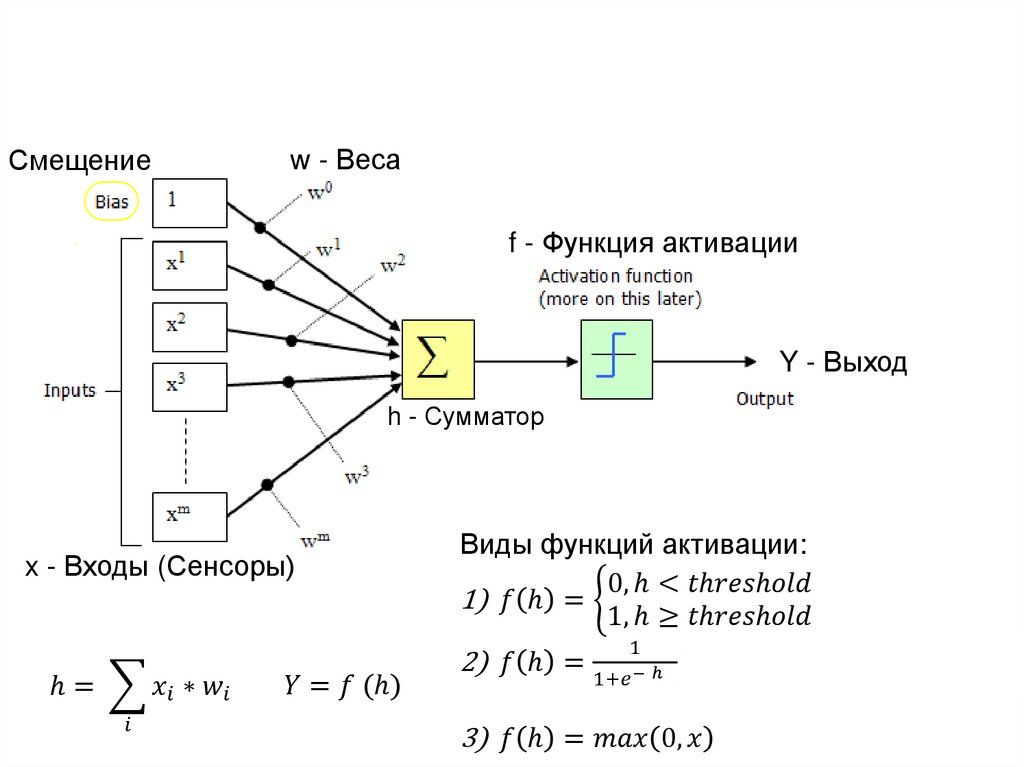

In [519]:
Image('images/perc1.png')

А вот он в виде кода

In [520]:
class Neuron:
    def __init__(self, nin): # `m` с картинки это `nin`
        # веса изначально инициализируются рандомно
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
  
    # через __call__ мы будем пропускать x через нейрон
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x))) + self.b
        out = act.tanh()
        return out
  
    def parameters(self):
        return self.w + [self.b]

В коде нейрона мы использовали функцию `tanh` (гиперболический тангенс). Добавим ее в `Value`  
Она используется в нейронных сетях, чтобы сделать нейрон нелинейной функцией

In [521]:
def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
        self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

Value.tanh = tanh

In [522]:
x = [2.0, 3.0]
n = Neuron(2) # нейрон, который принимает два входа
n(x)

Value(data=-0.9439808520508457)

### Нейронные сети в основном состоят из слоёв нейронов.
Слои бывают разных типов  
На картинке изображен Полносвязный слой (про другие на следующей лекции)   
Так же он может называться: Линейный, Linear, Fully Connected, Dense aka Дремучий🥴  
Полносвязный слой в свою очередь состоит из нескольких нейронов.  

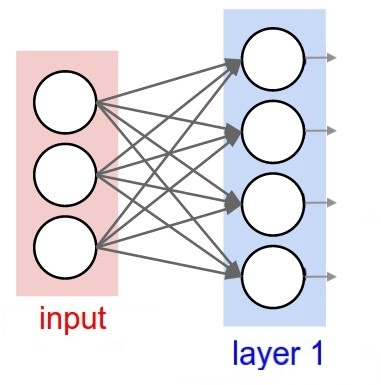

In [523]:
Image("images/layer.jpeg")

`nin` - количество входов, которые принимает слой. И одновременно сколько принимает каждый нейрон в слое  
`nout` - количество нейронов в слое. И одновременно сколько выходов у слоя (тк каждый нейрон возвращает одно значение)

In [524]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

### Теперь сделаем MLP (Multi layer perceptron)(Многослойный перцептрон)
Который уже сам по себе является нейросетью.  
Он состоит из нескольких своёв. Каждоый последующий слой принимает сколько входов, сколько выходов вернул предыдущий слой

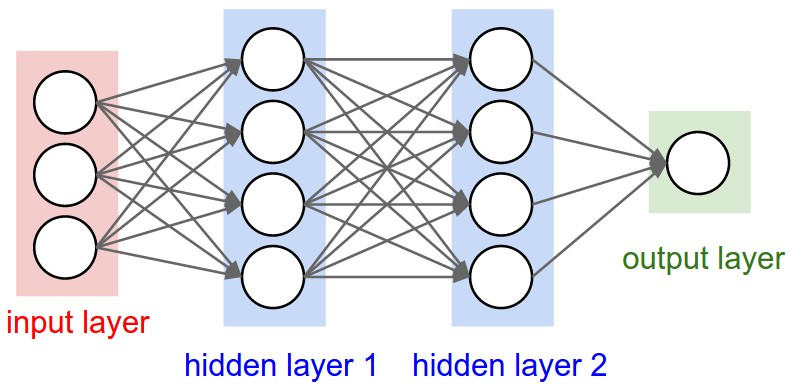

In [525]:
Image("images/mlp.png")

`nin` - количество входов, которые принимает первый слой.
`nout` - список, сколько нейронов в каждом слое

In [526]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [527]:
# реализуем картинку выше
model = MLP(3, [4, 4, 1])
x = [2, 3, 4]
model(x)

Value(data=-0.018692133109025667)

Если бы в наших нейронах не было нелинейной функции активации, то несколько слоев можно было бы заменять одним

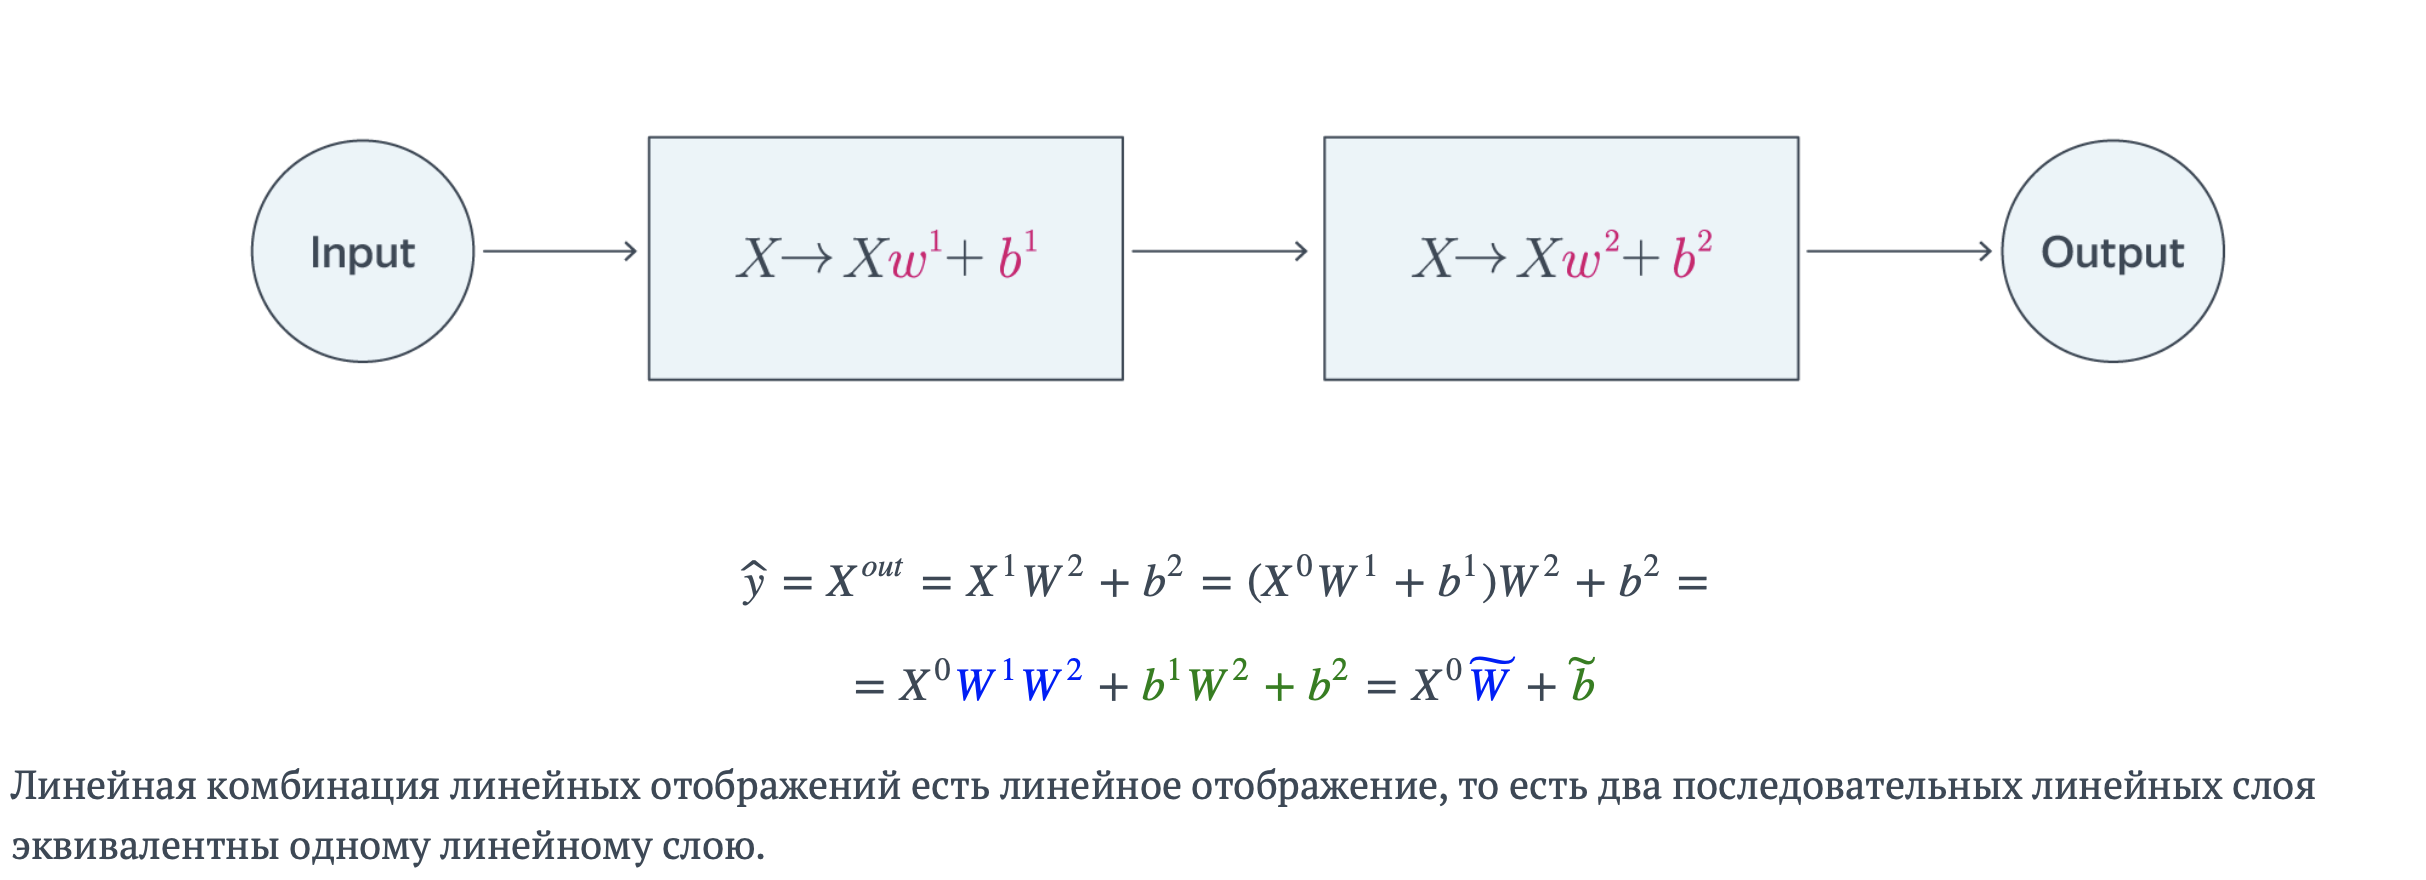

In [716]:
Image('images/2linear.png', width=800)

### FYI

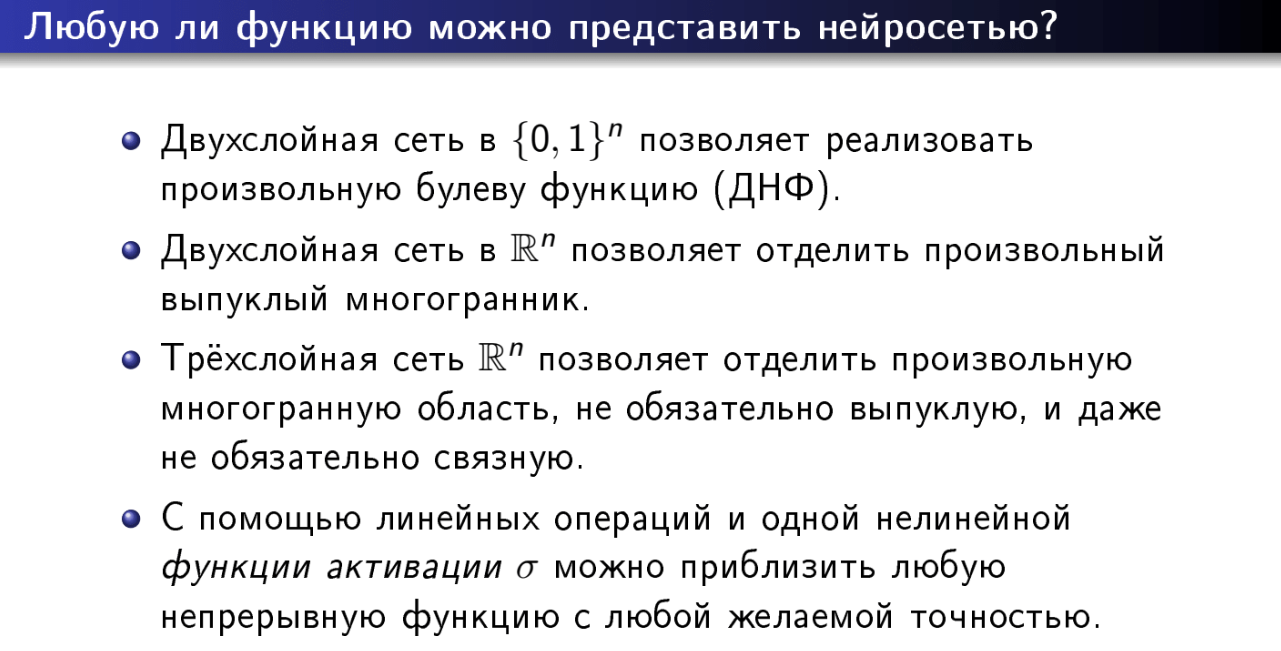

In [714]:
Image('images/percres.png', width=800)

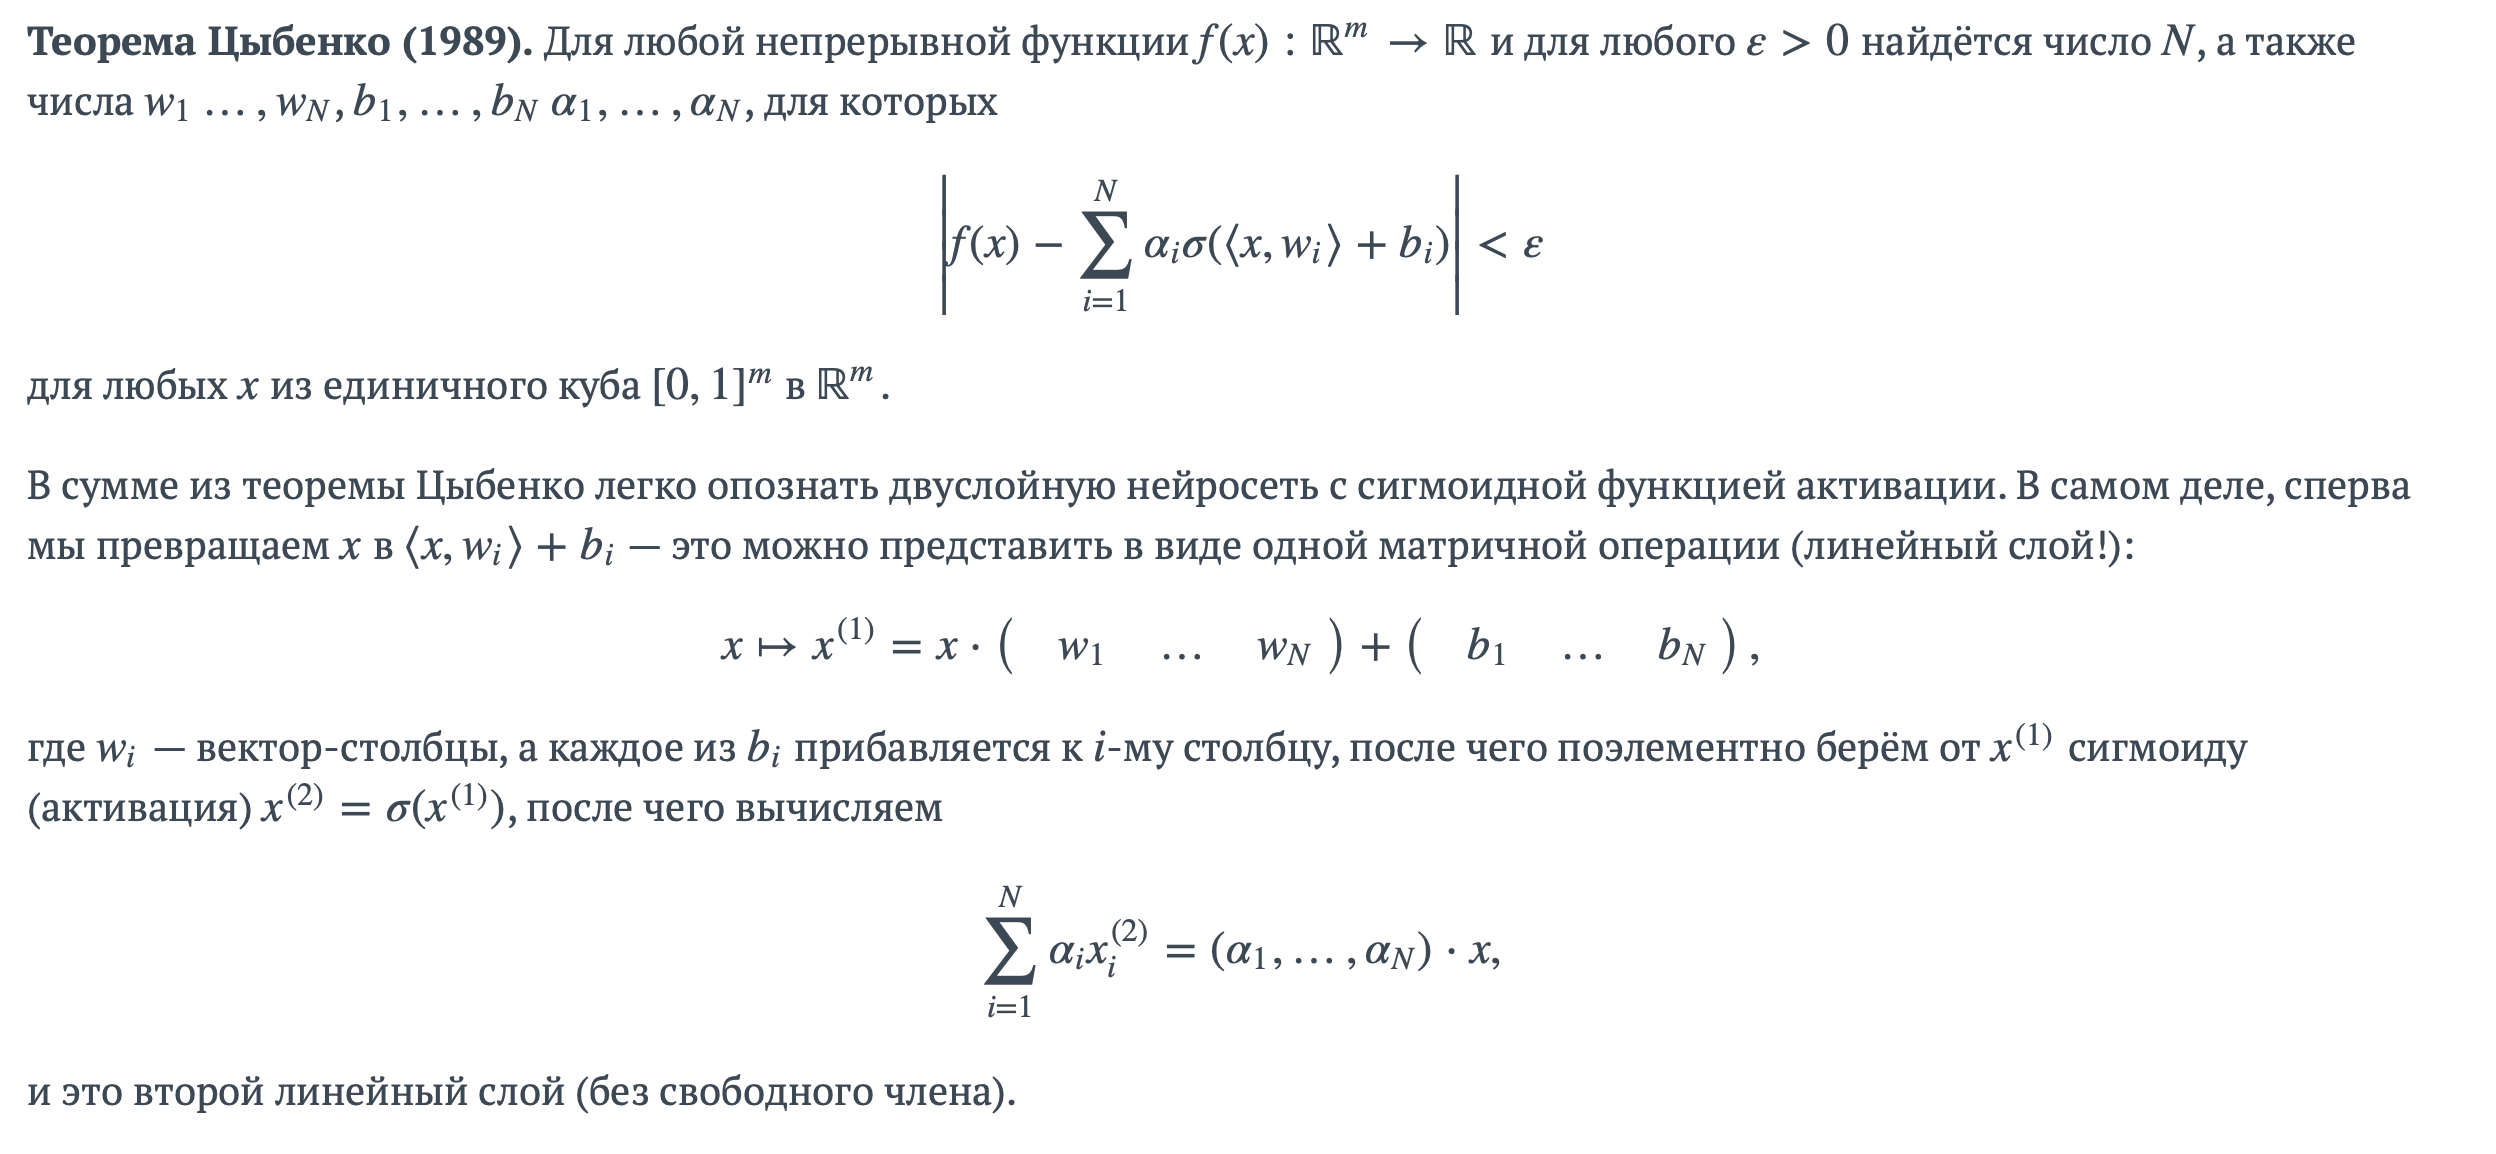

In [715]:
Image('images/cybenko.png', width=800)

## Обучим нашу нейронку на каком-нибудь мини датасете

Вот датасетик с 4мя примерами

In [528]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, 0, 0, 1.0]

In [671]:
# датасете у каждого примера 3 фичи, поэтому первый аргумент - 3
# Потом пусть стоят два слоя по 4 нейрона, и в конце один на один нейрон, чтобы на выходе получить одно число - как в `y`
model = MLP(3, [4, 4, 1])

In [672]:
[model(x) for x in xs]

[Value(data=-0.8470878826615088),
 Value(data=-0.9246930654998129),
 Value(data=-0.9214680118322552),
 Value(data=-0.8329951722241365)]

Пока предсказания так себе

Чтобы это исправить, надо как в начале ноутбука, посчитать разницу между выходами модели и правильными ответами и итеративно минимизировать эту разницу

In [673]:
def loss(y_preds, y_targets):
    return sum([(pred - y) ** 2 for pred, y in zip(y_preds, y_targets)]) / len(y_targets)

In [674]:
preds = [model(x) for x in xs]
loss_value = loss(preds, ys)
print(loss_value)

Value(data=2.118941307067871)


In [675]:
loss_value.backward()

In [676]:
# это число означает, какой импакт внес этот парамент в размер лосса
# нам надо двигать этот параметр в противоположную сторону
model.layers[0].neurons[0].w[0].grad

tensor(-0.2098)

In [677]:
def train(model, epoches):
    for k in range(epoches):
        # forward
        preds = [model(x) for x in xs]
        # calc loss
        loss_value = loss(preds, ys)
        
        # обнулим градиенты, после прошлого backward
        for p in model.parameters():
            p.grad = 0.0

        # посчитаем градиенты
        loss_value.backward()
        
        # обновим параметры
        for p in model.parameters():
            p.data += -0.1 * p.grad
        
        print(k, loss_value.data)

In [678]:
train(model, 20)

0 tensor(2.1189)
1 tensor(1.8127)
2 tensor(1.0434)
3 tensor(0.1817)
4 tensor(0.0526)
5 tensor(0.0443)
6 tensor(0.0389)
7 tensor(0.0347)
8 tensor(0.0312)
9 tensor(0.0283)
10 tensor(0.0258)
11 tensor(0.0237)
12 tensor(0.0218)
13 tensor(0.0202)
14 tensor(0.0188)
15 tensor(0.0175)
16 tensor(0.0164)
17 tensor(0.0154)
18 tensor(0.0145)
19 tensor(0.0136)
20 tensor(0.0129)
21 tensor(0.0122)
22 tensor(0.0116)
23 tensor(0.0110)
24 tensor(0.0105)
25 tensor(0.0100)
26 tensor(0.0096)
27 tensor(0.0092)
28 tensor(0.0088)
29 tensor(0.0084)
30 tensor(0.0081)
31 tensor(0.0078)
32 tensor(0.0075)
33 tensor(0.0073)
34 tensor(0.0070)
35 tensor(0.0068)
36 tensor(0.0066)
37 tensor(0.0064)
38 tensor(0.0062)
39 tensor(0.0060)
40 tensor(0.0058)
41 tensor(0.0056)
42 tensor(0.0055)
43 tensor(0.0053)
44 tensor(0.0052)
45 tensor(0.0051)
46 tensor(0.0049)
47 tensor(0.0048)
48 tensor(0.0047)
49 tensor(0.0046)
50 tensor(0.0045)
51 tensor(0.0044)
52 tensor(0.0043)
53 tensor(0.0042)
54 tensor(0.0041)
55 tensor(0.0040)
56

In [680]:
[model(x) for x in xs]

[Value(data=0.9604032250369481),
 Value(data=0.00048673149079901234),
 Value(data=0.0018388906255360374),
 Value(data=0.9542037862808446)]

# Тоже самое на pytorch

In [701]:
from torch import nn

In [702]:
# пишем какие операции использовать друг за другом
model = torch.nn.Sequential(
    nn.Linear(3, 4),
    nn.Tanh(),
    nn.Linear(4, 4),
    nn.Tanh(),
    nn.Linear(4, 1),
    nn.Tanh()
)

Зачастую используемая архитектура нетривиальная, базовые блоки торча по типу `nn.Linear`, `nn.Tanh`,   
а также их композиции, такие как `nn.Sequential` не позволяют описать прямой прогон сети.  
Для того, чтобы описать логику прогона в торче есть интерфейс, позволяющий писать кастомные модули  
https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [703]:
from torch import nn


class AmogusNet(nn.Module):
    # в init мы объявляем все слои и операции из которых будем строить сетку
    def __init__(self):
        super().__init__()
        self.liner1 = nn.Linear(3, 4)
        self.liner2 = nn.Linear(4, 4)
        self.liner3 = nn.Linear(4, 1)
        self.tanh = nn.Tanh()
    
    # в forward надо написать, как мы вычисляем результат
    # когда мы пишем model(x) под капотом вызывается __call__, а __call__ вызывает forward
    def forward(self, x):
        x = self.liner1(x)
        x = self.tanh(x)
        x = self.liner2(x)
        x = self.tanh(x)
        x = self.liner3(x)
        x = self.tanh(x)
        return x.squeeze()

In [704]:
model = AmogusNet()

In [682]:
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs)
print(ys)

tensor([[ 2.0000,  3.0000, -1.0000],
        [ 3.0000, -1.0000,  0.5000],
        [ 0.5000,  1.0000,  1.0000],
        [ 1.0000,  1.0000, -1.0000]])
tensor([1., 0., 0., 1.])


In [705]:
model(xs)

tensor([0.4067, 0.4493, 0.3122, 0.4004], grad_fn=<SqueezeBackward0>)

In [697]:
def train(model, loss, epoches):
    for k in range(epoches):
        preds = model(xs)
        loss_value = loss(ys, preds)
        
        model.zero_grad()
        loss_value.backward()
        
        with torch.no_grad(): # чтобы руками шатать градиенты в параментрах модели надо писать no_grad
            for param in model.parameters():
                param += -0.1 * param.grad
        
        print(k, loss_value.data)

In [706]:
# вообще подошел бы и наш лосс, написанный в ручную, но в торче есть встроенный
mse_loss = nn.MSELoss()
model = AmogusNet()

In [699]:
train(model, mse_loss, 20)

0 tensor(0.0150)
1 tensor(0.0142)
2 tensor(0.0135)
3 tensor(0.0128)
4 tensor(0.0122)
5 tensor(0.0117)
6 tensor(0.0112)
7 tensor(0.0107)
8 tensor(0.0102)
9 tensor(0.0098)
10 tensor(0.0094)
11 tensor(0.0091)
12 tensor(0.0088)
13 tensor(0.0084)
14 tensor(0.0082)
15 tensor(0.0079)
16 tensor(0.0076)
17 tensor(0.0074)
18 tensor(0.0071)
19 tensor(0.0069)


# Оптимайзеры?

Вообще, есть более умные способы опримизации нейронных сетей, чем стохастический градиентый спуск (SGD), который мы написал выше.  
SGD не всегда быстро находит минимум на поверхности функции потерь (если вообще находит)  
Вот есть гифка, где разные алгоритмы оптимизации (оптимайзеры) ищут минимум  
Нашли ~~себя~~ SGD на этой картинке? Он застрял посередине седла

![title](https://cs231n.github.io/assets/nn3/opt1.gif)

Если в двух словах, то "умные" оптимизаторы, добавляют параметрам физические свойства (например ускорение)  
И считают разные статистики (например усредняя направление движения за последние несколько шагов)

В среднем можно всегда брать `Adam`  
Перепишем обучение сеточки с ним

In [707]:
def train(model, loss, optimizer, epoches):
    for k in range(epoches):
        # forward
        preds = model(xs)
        # calc loss
        loss_value = loss(preds, ys)
        # set grad to zero
        model.zero_grad()
        # calc grad
        loss_value.backward()
        # update weights
        optimizer.step()

        print(k, loss_value.data)

In [710]:
model = AmogusNet()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

In [711]:
train(model, loss, optimizer, 20)

0 tensor(0.2550)
1 tensor(0.1587)
2 tensor(0.0544)
3 tensor(0.0678)
4 tensor(0.0353)
5 tensor(0.0132)
6 tensor(0.0406)
7 tensor(0.0083)
8 tensor(0.0174)
9 tensor(0.0249)
10 tensor(0.0045)
11 tensor(0.0159)
12 tensor(0.0149)
13 tensor(0.0022)
14 tensor(0.0085)
15 tensor(0.0130)
16 tensor(0.0066)
17 tensor(0.0039)
18 tensor(0.0074)
19 tensor(0.0063)


### Так и еще раз на закрепление train loop:
* FORWARD (посчитали вперед по существующей сети)
* LOSS (посчитали ошибку)
* ZERO_GRAD (обнулили градиенты)
* BACKWARD (посчитали производные)
* UPDATE Weights (обновили веса)


# Функции активации

Бывает много разных функций активации. С ними можно экспериментировать.  
Но в среднем можно ставить `nn.ReLU` и норм.  

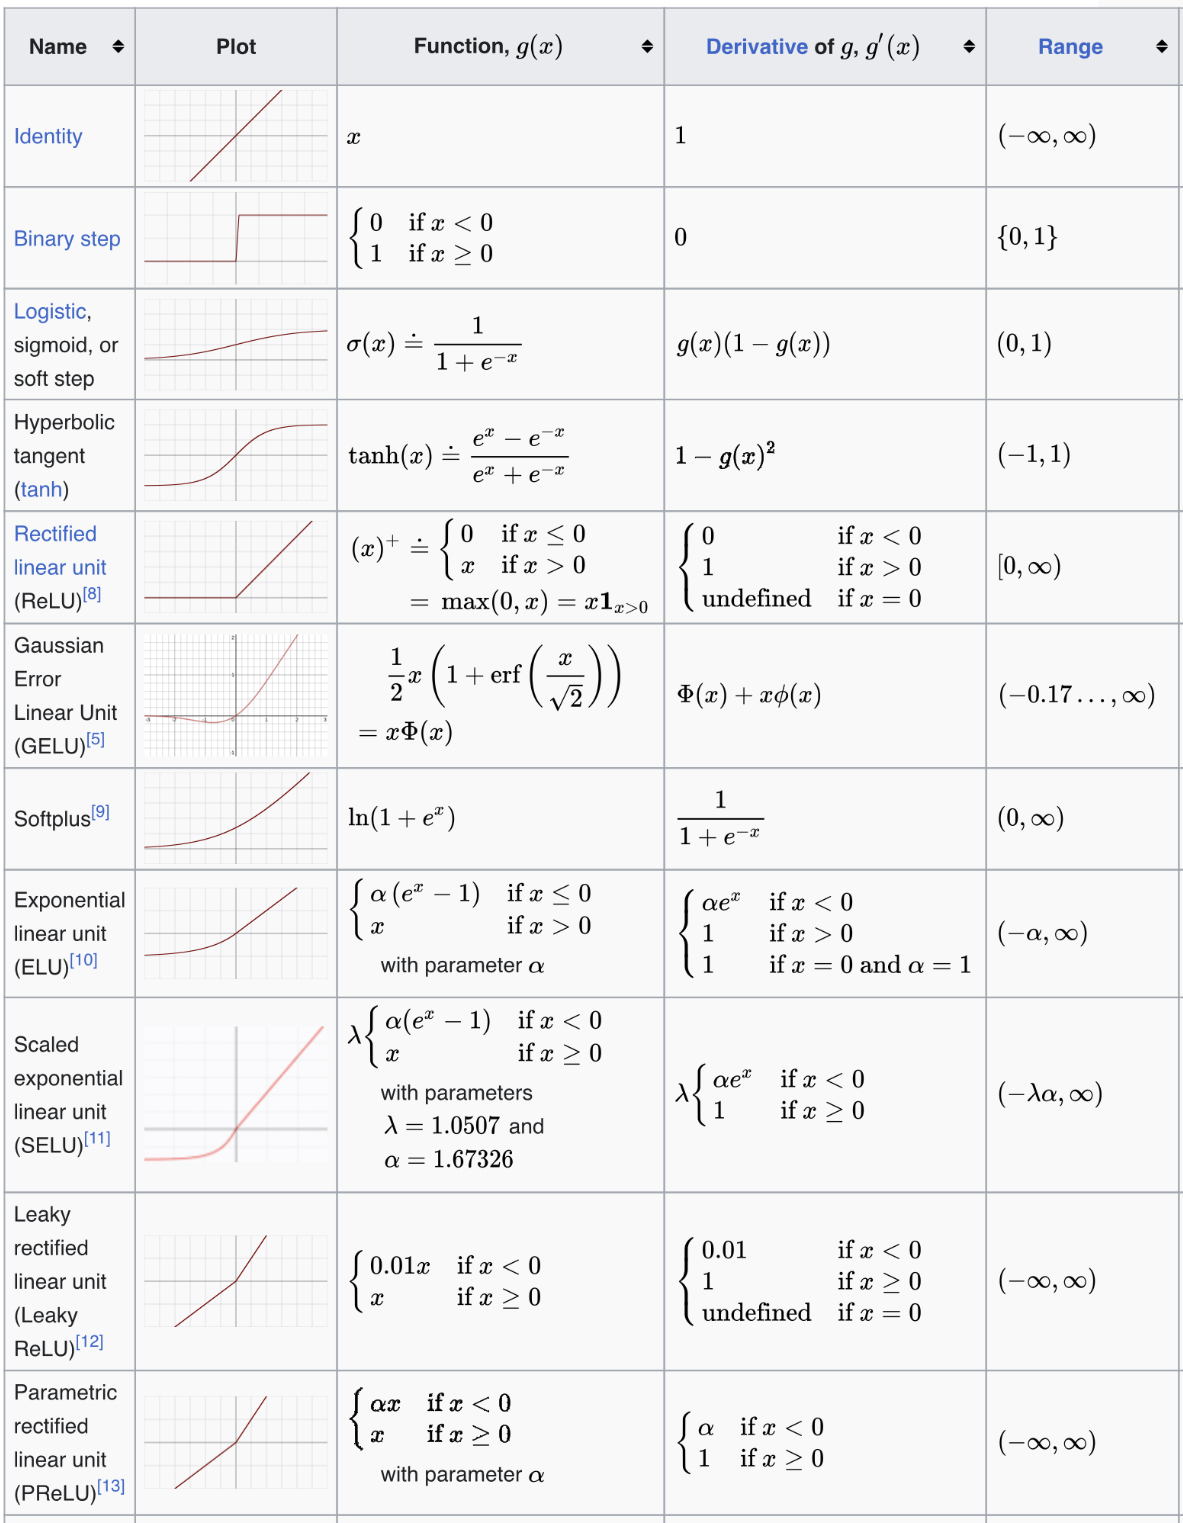

In [712]:
Image("images/activations2.jpg")

# Для нейронок же нужны видюхи?

Да, если у вас есть видюха nvidia*, можно обучать и запускать нейронки.  
Так будет на несколько порядков бысрее чем на проце  

In [713]:
# если false, то торч не видит видюху
torch.cuda.is_available()

False

Отличие в обучении будет только такое:   
Надо перенести модель и данные на гпу

In [ ]:
def train(model, loss, optimizer, epoches):
    # переместим все "числа" на видюху
    model = model.to('cuda')
    ys = ys.to('cuda')
    xs = xs.to('cuda')

    for k in range(epoches):
        preds = model(xs)
        loss_value = loss(preds, ys)
        model.zero_grad()
        loss_value.backward()
        optimizer.step()

        print(k, loss_value.data)

# Занимательные ссылки
* Начало лекции сделано на основе этого [видоса](https://www.youtube.com/watch?v=VMj-3S1tku0)
* [Видос про Autograd](https://www.youtube.com/watch?v=DbeIqrwb_dE)
* [Видео автоматическое взятие производных](https://www.youtube.com/watch?v=wG_nF1awSSY)
* [Видос про CUDA](https://www.youtube.com/watch?v=M2YWnv5cLBo)
* [Как считается производная?](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/)
* [Сравнение torch tensor и numpy array](https://medium.com/@ashish.iitr2015/comparison-between-pytorch-tensor-and-numpy-array-de41e389c213)
* [Численное дифференцирование](https://ru.wikipedia.org/wiki/%D0%A7%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B5_%D0%B4%D0%B8%D1%84%D1%84%D0%B5%D1%80%D0%B5%D0%BD%D1%86%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)

* [Видео по алгоритму](https://www.youtube.com/watch?v=tIeHLnjs5U8)
* [Методичка Воронцова по нейронкам](http://ultra27.ccas.ru/voron/download/NeuralNets.pdf)
* [Видос Воронцова, откуда взяты слайды](https://www.youtube.com/watch?v=zbdgUZAzfQg&list=PLJOzdkh8T5krxc4HsHbB8g8f0hu7973fK&index=13)
* [Анимации градиентных спусков](http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html)
* [Про softmax](https://konstantinklepikov.github.io/2019/06/27/cs2131n-sofrmax.html)
* [Softmax better than Normalization](https://stackoverflow.com/questions/17187507/why-use-softmax-as-opposed-to-standard-normalization)